# Simple Decoder (Many-to-Many) with LSTM in Pytorch
This is a simple encoder/decoder module with the Many-to-Many simple pattern. This means that the outtput sequence size must match the input sequence size.
![alt text](imgs/sequnce_types.png "Types")

### Problem
The input message will be encrypted simply by adding 2 elements on alphabet position (ie: A-->C, B-->D, etc...)

### Creating LSTM layer in Pytorch easy way
```python
# Step 1
lstm = torch.nn.LSTM(input_size=5, hidden_size=10, batch_first=True)
```

### References
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://medium.com/@nikhilweee/building-your-first-rnn-with-pytorch-8568b6f2ec71
* https://towardsdatascience.com/3-silver-bullets-of-word-embedding-in-nlp-10fa8f50cc5a
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
* https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones
* https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
* https://www.quora.com/What-does-PyTorch-Embedding-do
* https://stackoverflow.com/questions/50747947/embedding-in-pytorch

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

vocab = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-']
num_epochs = 10

batch_size = 128
embedding_dim = 10
vocab_size = len(vocab)

### Encode Function

In [2]:
# Jumpt 13 characters
def encrypt(text, key = 2):
    """Returns the encrypted form of 'text'."""
    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(idx + key) % len(vocab) for idx in indexes]
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    return encrypted


def decrypt(text, key = 2):
    """Returns the encrypted form of 'text'."""
    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(idx - key) % len(vocab) for idx in indexes]
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    return encrypted

print(encrypt('ABCDEFGHIJKLMNOPQRSTUVWXYZ-'))
enc_msg = encrypt('LEO')
print('Encrypted:',enc_msg)
dec_msg = decrypt(enc_msg)
print('Decrypted:',dec_msg)

CDEFGHIJKLMNOPQRSTUVWXYZ-AB
Encrypted: NGQ
Decrypted: LEO


### Create a dataset
Create a list size (batch_size) of encrypted/decrypted message tensors.

#### Some important points about sequence Modelling
On Sequence training, each sample on the batch need to follow some order, but the samples on the batch doesnt need to have correlation in time between themselves.

Also in theory the samples inside the batch doesnt need to have the same size

In [3]:
def dataset(batch_size, message_length = 32):
    """Returns a list of 'num_examples' pairs of the form (encrypted, original).

    Both elements of the pair are tensors containing indexes of each character
    of the corresponding encrypted or original message.
    """
    # We could change the sample size in between samples on the same batch
    message_length = random.randint(10, 32)
    dataset = []
    for x in range(batch_size):
        ex_out = ''.join([random.choice(vocab) for x in range(message_length)])
        # may be: MANR-TQNNAFEGIDE-OXQZANSVEMJXWSU
        ex_in = encrypt(''.join(ex_out))
        
        # may be: ZN-DMFC--NSRTVQRMAJCLN-EHRZWJIEG (Model Input)
        ex_in = [vocab.index(x) for x in ex_in]
        # may be: [25, 13, 26, 3, 12, 5, 2, 26, 26, (Model Label)
        ex_out = [vocab.index(x) for x in ex_out]
        
        # Return a batch
        # may be: [12, 0, 13, 17, 26, 19, 16, 13, ...
        dataset.append([torch.tensor(ex_in), torch.tensor(ex_out)])
    return dataset

### Define and instantiate LSTM Decoder Model

In [4]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim = 8):
        super(DecoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        # Create Embedding of "vocabulary size tensors" of size "embedding_dim"
        self.embed = torch.nn.Embedding(vocab_size, embedding_dim)
        # Create LSTM layer (input_size, size_hidden_features)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)
        # Create FC layer (input_size, output_size)
        self.linear = torch.nn.Linear(hidden_dim, vocab_size)
        # Create Softmax Layer
        self.softmax = torch.nn.functional.softmax

    def forward(self, input):
        # Convert the letters to dense vectors (Easier for the LSTM to learn)
        lstm_in = self.embed(input)
        # Add extra dimentsion to the input
        lstm_in = lstm_in.unsqueeze(1)
        
        # Run the LSTM layer with a batch of samples
        lstm_out, lstm_hidden = self.lstm(lstm_in, self.initHidden())
        
        # Run the FC layer
        scores = self.linear(lstm_out)
        
        # Run softmax layer (Convert to probabilities)
        predictions = self.softmax(scores, dim=2)
        return scores, predictions

    # Initialize hiddem and cell state before each batch
    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),torch.zeros(1, 1, self.hidden_dim))


decoder_lstm = DecoderLSTM(vocab_size=vocab_size, embedding_dim=embedding_dim)

### Instantiate loss

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

### Instantiate Optimizer

In [6]:
optimizer = torch.optim.Adam(decoder_lstm.parameters(), lr=0.001)

### Train

Epoch: 0
Loss: 3.1466
Epoch: 1
Loss: 2.8361
Epoch: 2
Loss: 2.3299
Epoch: 3
Loss: 2.0675
Epoch: 4
Loss: 1.5893
Epoch: 5
Loss: 1.3763
Epoch: 6
Loss: 1.2076
Epoch: 7
Loss: 0.9377
Epoch: 8
Loss: 0.8511
Epoch: 9
Loss: 0.6529


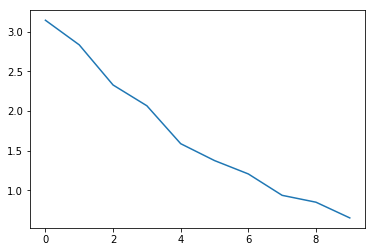

In [7]:
accuracies, max_accuracy = [], 0
all_losses = []
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted_msgs, label_msgs in dataset(batch_size):
        optimizer.zero_grad()
        scores,_ = decoder_lstm(encrypted_msgs)
        # scores.size() = [64, 1, 27], but loss_fn expects a tensor
        # of size [64, 27, 1]. So we switch the second and third dimensions.
        scores = scores.transpose(1, 2)
        # original.size() = [64], but original should also be a 2D tensor
        # of size [64, 1]. So we insert a fake dimension.
        label_msgs = label_msgs.unsqueeze(1)
        # Calculate loss.
        loss = loss_fn(scores, label_msgs) 
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    all_losses.append(loss.item())
    print('Loss: {:6.4f}'.format(loss.item()))

plt.figure()
plt.plot(all_losses)

### Validate

In [8]:
with torch.no_grad():
        matches, total = 0, 0
        for encrypted_msgs, label_msgs in dataset(batch_size):
            scores,predictions = decoder_lstm(encrypted_msgs)
            # Choose the letter with the maximum probability
            _, batch_out = predictions.max(dim=2)
            # Remove fake dimension
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, label_msgs).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Accuracy: 100.00%


### Test on a single message

In [9]:
sample = dataset(1)
encrypted_msgs = sample[0][0]
label_msgs = sample[0][1]
print('\nLabel text (Expected output)')
label_msgs_chars = [vocab[char] for char in label_msgs]
print(label_msgs_chars)


Label text (Expected output)
['M', 'K', 'P', 'X', 'N', 'Z', 'E', 'G', 'S', 'Z', 'R', 'N', 'U', 'I', '-', 'D']


In [10]:
scores,predictions = decoder_lstm(encrypted_msgs)
_, batch_out = predictions.max(dim=2)
batch_out = batch_out.squeeze(1)
decrypted_msg_model = batch_out.numpy()

print('Input:',encrypted_msgs.numpy())
print('\nExpected output:',label_msgs.numpy())
print('\nModel output:',decrypted_msg_model)

print('\nDecrypted text')
decrypted_msg_chars = [vocab[char] for char in decrypted_msg_model]
print(decrypted_msg_chars)

Input: [14 12 17 25 15  0  6  8 20  0 19 15 22 10  1  5]

Expected output: [12 10 15 23 13 25  4  6 18 25 17 13 20  8 26  3]

Model output: [12 10 15 23 13 25  4  6 18 25 17 13 20  8 26  3]

Decrypted text
['M', 'K', 'P', 'X', 'N', 'Z', 'E', 'G', 'S', 'Z', 'R', 'N', 'U', 'I', '-', 'D']
